In [1]:
#single_image = r"C:\Users\danie\Desktop\tiny rainbow.jpg"
image_folder = r"C:\Users\midyr\Downloads\colorwheels"
image_pathway = r"C:\Users\midyr\Downloads\traffic4.jpg"

TOO_SMALL = 20
SMALL = 500000
MEDIUM = 1200000
LARGE = 2100000
    
X_train = []
Y_train = []
counter = 1
    
height = 256
width = 256

total_images = 1

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import glob
import cv2
import pandas as pd
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, UpSampling2D, InputLayer, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import data, io, color
from skimage.io import imread, imshow, imsave
from pathlib import Path

from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
def shape(img):
    size = 0
    resolution = img.shape[0] * img.shape[1]
    if resolution <= TOO_SMALL:
        size = 0
    elif resolution <= SMALL:
        size = 1
    elif resolution <= MEDIUM:
        size = 2
    elif resolution <= LARGE:
        size = 3
    else:
        size = 6
    return size

In [4]:
def create_dataframe(image_folder):
    images = Path(image_folder).glob('*.jpg') #.png

    list_of_files = []
    for image in images:
        list_of_files.append(str(image))

    df = pd. DataFrame(list_of_files, columns = ["image_path"])
    df_length = len(df.index)
    
    print("processing", df_length, "photos for training")
    
    height_list= []
    width_list = []
    resolution = []
    
    for image_path in df['image_path']:
        img = cv2.imread(str(image_path))
        height_list.append(img.shape[0])
        width_list.append(img.shape[1])
        
    df["height"] = height_list
    df["width"] = width_list
    df["resolution"] = df["height"] * df["width"]
    
    df = df[df.resolution < LARGE]
    
    ll = df_length - len(df.index)
    print("dropped ", ll, "photos because they were too large to process")
    
    df = df[df.resolution > TOO_SMALL]
    
    ss = df_length - len(df.index) - ll
    print("dropped ", ss, "photos because they were too small to process")
    df.head()
    
    return df

In [5]:
def pca_rgb(imgBGR, size): #imgRGB, size
    b,g,r = cv2.split(imgBGR)
    list_channels = [b,g,r]
    
    #check size first
    if size ==1:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 100)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)    

    elif size == 2:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 300)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
    else:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 500)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
        
    RGB_compressed = np.float32(RGB_compressed)
    print("PCA SHAPE",np.min(RGB_compressed),np.max(RGB_compressed))    
    return RGB_compressed

In [6]:
def rgb_pad(image):
    
    img_height = image.shape[0]
    print(height)
    img_width = image.shape[1]
    print(width)
    
    WHITE = [255,255,255] #[255,255,255]  1, 1, 1
    
    if img_height % 2 == 0:
        top = int((height - img_height)/ 2)
        bottom = int((height - img_height)/ 2)
    else: 
        top = int((height - (img_height-1))/ 2)
        bottom = int(((height - (img_height-1))/ 2)-1)

    if img_width % 2 == 0:
        left = int((width - img_width)/ 2)
        right = int((width - img_width)/ 2)
    else: 
        left = int((width - (img_width-1))/ 2)
        right = int(((width - (img_width-1))/2)-1)
    
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,value=WHITE)
    print(image.shape)
    print(np.min(image),np.max(image))

    return image

In [7]:
def prep_img(img_path):
    imgRGB = img_to_array(load_img(img_path))
    imgRGB = np.array(imgRGB, dtype=float)
    print('Padded:', np.min(imgRGB), np.max(imgRGB))



    image_size_category = shape(imgRGB) 
    if image_size_category <1:
        raise Exception("Your image is too small to be used")
    elif image_size_category >4:
        raise Exception("Your image is too big to be used")

    if PCA_YN == "yes":
        RGB_compressed = pca_rgb(imgRGB, image_size_category)
        RGB_compressed = np.clip(RGB_compressed,0,1) * 255
        print("PCA ran")
    else:
        RGB_compressed = imgRGB
        print("PCA did not run")


    
    padded_image = rgb_pad(RGB_compressed)

    print('Padded:', np.min(padded_image), np.max(padded_image))
    X_LAB = color.rgb2lab(1.0/255*padded_image)[:,:,0] #1.0/255*padded_image
    print('X_LAB:', np.min(X_LAB), np.max(X_LAB))
    Y_LAB1 = color.rgb2lab(1.0/255*padded_image)[:,:,1:] #1.0/255*padded_image
    print('Y_LAB_org:', np.min(Y_LAB1), np.max(Y_LAB1))
    #Y_LAB = Y_LAB1 / 128
    Y_LAB = (Y_LAB1 + 128)/ 256
    print('Y_LAB:', np.min(Y_LAB), np.max(Y_LAB))


    print(X_LAB.shape)
    X = X_LAB.reshape(1, height, width, 1) #comment out when show predicted
    Y = Y_LAB.reshape(1, height, width, 2) #comment out when show predicted
    
    print("image processed")

    return Y, X 

In [8]:
def prep_dataframe(df):
    for index, row in df.iterrows():
        Y, X = prep_img(row["image_path"])
        Y_train.append(Y)
        X_train.append(X)

In [9]:
PCA_YN = "no"

#prep_image(single_image)

df = create_dataframe(image_folder)
prep_dataframe(df)

processing 4 photos for training
dropped  0 photos because they were too large to process
dropped  0 photos because they were too small to process
Padded: 0.0 255.0
PCA did not run
256
256
(256, 256, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.17702971378012577 100.0
Y_LAB_org: -71.17268893328688 77.75729265802376
Y_LAB: 0.22198168385434813 0.8037394244454052
(256, 256)
image processed
Padded: 0.0 255.0
PCA did not run
256
256
(256, 256, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.039573654069084085 100.0
Y_LAB_org: -90.63866915032773 83.20574458892847
Y_LAB: 0.1459426986315323 0.8250224398005018
(256, 256)
image processed
Padded: 0.0 255.0
PCA did not run
256
256
(256, 256, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.8013688253736433 100.0
Y_LAB_org: -48.95291303408261 90.26595316207187
Y_LAB: 0.3087776834606148 0.8526013795393432
(256, 256)
image processed
Padded: 0.0 255.0
PCA did not run
256
256
(256, 256, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.4324681123001284 99.45842141301871
Y_LAB_org: -3

# MODEL

In [10]:
BATCH_SIZE = 3
LEARNING_RATE = 0.001 #0.001
EPOCHS = 500 #500
KERNEL_SIZE = 2 
NUM_CLASSES = 64 #64
#IMAGE_WIDTH = 128 #128
#IMAGE_HEIGHT = 128 #128
#SIGMA = 5

In [57]:
def mode():
   
    model = tf.keras.Sequential([
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', strides=(2, 2)),
    BatchNormalization(),

    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    BatchNormalization(),

    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    Conv2D(512, kernel_size=KERNEL_SIZE, activation='relu', padding='same', dilation_rate=2),
    BatchNormalization(),

    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(256, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    UpSampling2D(size=(2, 2)),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    Conv2D(128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(NUM_CLASSES, kernel_size=KERNEL_SIZE, padding='same'),
    Conv2D(NUM_CLASSES, kernel_size=KERNEL_SIZE, padding='same'),
    Conv2D(NUM_CLASSES, kernel_size=KERNEL_SIZE, padding='same'),
    BatchNormalization(),
        
    UpSampling2D(size=(2, 2)),
    Conv2D(16, kernel_size=KERNEL_SIZE, padding='same'),    
    Conv2D(16, kernel_size=KERNEL_SIZE, padding='same'),
    Conv2D(16, kernel_size=KERNEL_SIZE, padding='same'),    
    BatchNormalization(), 
        
    Conv2D(2, kernel_size=KERNEL_SIZE, padding='same'),
    Conv2D(2, kernel_size=KERNEL_SIZE, padding='same'),
    Conv2D(2, kernel_size=KERNEL_SIZE, padding='same'),
    BatchNormalization(),
        
    UpSampling2D(size=(2, 2))])
    
    model.compile(optimizer ="rmsprop", loss = "mse", metrics = ["accuracy"])
    
    return model 

#?? Acitivation function and Loss function #CategoricalCrossentropy
#Conv2D(NUM_CLASSES, kernel_size=1, padding='same', activation='softmax'), UpSampling2D(size=(4, 4))])

In [41]:
model = mode()

In [42]:
model.build((1,256,256,1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (1, 256, 256, 64)         320       
                                                                 
 conv2d_63 (Conv2D)          (1, 128, 128, 64)         16448     
                                                                 
 batch_normalization_22 (Bat  (1, 128, 128, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_64 (Conv2D)          (1, 128, 128, 128)        32896     
                                                                 
 conv2d_65 (Conv2D)          (1, 64, 64, 128)          65664     
                                                                 
 batch_normalization_23 (Bat  (1, 64, 64, 128)         512       
 chNormalization)                                     

In [43]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

In [44]:
len(X_train)

4

In [45]:
%%time
history = model.fit(train_data, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 2)  # add validation_split = 0.2

Epoch 1/500
4/4 - 5s - loss: 1.2797 - accuracy: 0.4910 - 5s/epoch - 1s/step
Epoch 2/500
4/4 - 2s - loss: 1.2440 - accuracy: 0.5129 - 2s/epoch - 503ms/step
Epoch 3/500
4/4 - 2s - loss: 1.2156 - accuracy: 0.4958 - 2s/epoch - 517ms/step
Epoch 4/500
4/4 - 2s - loss: 1.1901 - accuracy: 0.5038 - 2s/epoch - 535ms/step
Epoch 5/500
4/4 - 2s - loss: 1.1720 - accuracy: 0.5103 - 2s/epoch - 499ms/step
Epoch 6/500
4/4 - 2s - loss: 1.1679 - accuracy: 0.5094 - 2s/epoch - 523ms/step
Epoch 7/500
4/4 - 2s - loss: 1.1185 - accuracy: 0.5334 - 2s/epoch - 507ms/step
Epoch 8/500
4/4 - 2s - loss: 0.9622 - accuracy: 0.4710 - 2s/epoch - 499ms/step
Epoch 9/500
4/4 - 2s - loss: 0.7640 - accuracy: 0.4793 - 2s/epoch - 497ms/step
Epoch 10/500
4/4 - 2s - loss: 0.7114 - accuracy: 0.4655 - 2s/epoch - 499ms/step
Epoch 11/500
4/4 - 2s - loss: 0.6793 - accuracy: 0.5387 - 2s/epoch - 495ms/step
Epoch 12/500
4/4 - 2s - loss: 0.6815 - accuracy: 0.4540 - 2s/epoch - 497ms/step
Epoch 13/500
4/4 - 2s - loss: 0.6578 - accuracy: 0.4

Epoch 104/500
4/4 - 2s - loss: 0.0212 - accuracy: 0.6252 - 2s/epoch - 505ms/step
Epoch 105/500
4/4 - 2s - loss: 0.0206 - accuracy: 0.5836 - 2s/epoch - 495ms/step
Epoch 106/500
4/4 - 2s - loss: 0.0203 - accuracy: 0.5615 - 2s/epoch - 484ms/step
Epoch 107/500
4/4 - 2s - loss: 0.0188 - accuracy: 0.6309 - 2s/epoch - 495ms/step
Epoch 108/500
4/4 - 2s - loss: 0.0180 - accuracy: 0.6228 - 2s/epoch - 490ms/step
Epoch 109/500
4/4 - 2s - loss: 0.0168 - accuracy: 0.6151 - 2s/epoch - 474ms/step
Epoch 110/500
4/4 - 2s - loss: 0.0162 - accuracy: 0.6447 - 2s/epoch - 477ms/step
Epoch 111/500
4/4 - 2s - loss: 0.0155 - accuracy: 0.6262 - 2s/epoch - 509ms/step
Epoch 112/500
4/4 - 2s - loss: 0.0154 - accuracy: 0.6316 - 2s/epoch - 506ms/step
Epoch 113/500
4/4 - 2s - loss: 0.0157 - accuracy: 0.5733 - 2s/epoch - 495ms/step
Epoch 114/500
4/4 - 2s - loss: 0.0134 - accuracy: 0.6175 - 2s/epoch - 481ms/step
Epoch 115/500
4/4 - 2s - loss: 0.0127 - accuracy: 0.6320 - 2s/epoch - 475ms/step
Epoch 116/500
4/4 - 2s - los

4/4 - 2s - loss: 0.0038 - accuracy: 0.7040 - 2s/epoch - 482ms/step
Epoch 206/500
4/4 - 2s - loss: 0.0031 - accuracy: 0.7200 - 2s/epoch - 481ms/step
Epoch 207/500
4/4 - 2s - loss: 0.0031 - accuracy: 0.7344 - 2s/epoch - 502ms/step
Epoch 208/500
4/4 - 2s - loss: 0.0031 - accuracy: 0.7312 - 2s/epoch - 479ms/step
Epoch 209/500
4/4 - 2s - loss: 0.0037 - accuracy: 0.6815 - 2s/epoch - 501ms/step
Epoch 210/500
4/4 - 2s - loss: 0.0035 - accuracy: 0.6753 - 2s/epoch - 488ms/step
Epoch 211/500
4/4 - 2s - loss: 0.0031 - accuracy: 0.7210 - 2s/epoch - 482ms/step
Epoch 212/500
4/4 - 2s - loss: 0.0034 - accuracy: 0.7122 - 2s/epoch - 482ms/step
Epoch 213/500
4/4 - 2s - loss: 0.0032 - accuracy: 0.6887 - 2s/epoch - 482ms/step
Epoch 214/500
4/4 - 2s - loss: 0.0030 - accuracy: 0.7147 - 2s/epoch - 478ms/step
Epoch 215/500
4/4 - 2s - loss: 0.0029 - accuracy: 0.7307 - 2s/epoch - 482ms/step
Epoch 216/500
4/4 - 2s - loss: 0.0031 - accuracy: 0.7255 - 2s/epoch - 481ms/step
Epoch 217/500
4/4 - 2s - loss: 0.0039 - ac

Epoch 307/500
4/4 - 2s - loss: 0.0022 - accuracy: 0.7149 - 2s/epoch - 510ms/step
Epoch 308/500
4/4 - 2s - loss: 0.0022 - accuracy: 0.7338 - 2s/epoch - 499ms/step
Epoch 309/500
4/4 - 2s - loss: 0.0022 - accuracy: 0.7243 - 2s/epoch - 486ms/step
Epoch 310/500
4/4 - 2s - loss: 0.0019 - accuracy: 0.7873 - 2s/epoch - 483ms/step
Epoch 311/500
4/4 - 2s - loss: 0.0021 - accuracy: 0.7596 - 2s/epoch - 481ms/step
Epoch 312/500
4/4 - 2s - loss: 0.0021 - accuracy: 0.7575 - 2s/epoch - 481ms/step
Epoch 313/500
4/4 - 2s - loss: 0.0021 - accuracy: 0.7439 - 2s/epoch - 479ms/step
Epoch 314/500
4/4 - 2s - loss: 0.0020 - accuracy: 0.7497 - 2s/epoch - 486ms/step
Epoch 315/500
4/4 - 2s - loss: 0.0020 - accuracy: 0.7298 - 2s/epoch - 496ms/step
Epoch 316/500
4/4 - 2s - loss: 0.0018 - accuracy: 0.7855 - 2s/epoch - 513ms/step
Epoch 317/500
4/4 - 2s - loss: 0.0019 - accuracy: 0.7595 - 2s/epoch - 502ms/step
Epoch 318/500
4/4 - 2s - loss: 0.0021 - accuracy: 0.7465 - 2s/epoch - 479ms/step
Epoch 319/500
4/4 - 2s - los

4/4 - 2s - loss: 0.0013 - accuracy: 0.7914 - 2s/epoch - 498ms/step
Epoch 409/500
4/4 - 2s - loss: 0.0013 - accuracy: 0.7900 - 2s/epoch - 482ms/step
Epoch 410/500
4/4 - 2s - loss: 0.0018 - accuracy: 0.7586 - 2s/epoch - 479ms/step
Epoch 411/500
4/4 - 2s - loss: 0.0015 - accuracy: 0.8049 - 2s/epoch - 515ms/step
Epoch 412/500
4/4 - 2s - loss: 0.0014 - accuracy: 0.7702 - 2s/epoch - 533ms/step
Epoch 413/500
4/4 - 2s - loss: 0.0016 - accuracy: 0.7564 - 2s/epoch - 508ms/step
Epoch 414/500
4/4 - 2s - loss: 0.0015 - accuracy: 0.7824 - 2s/epoch - 473ms/step
Epoch 415/500
4/4 - 2s - loss: 0.0015 - accuracy: 0.7995 - 2s/epoch - 472ms/step
Epoch 416/500
4/4 - 2s - loss: 0.0013 - accuracy: 0.7558 - 2s/epoch - 466ms/step
Epoch 417/500
4/4 - 2s - loss: 0.0014 - accuracy: 0.7821 - 2s/epoch - 466ms/step
Epoch 418/500
4/4 - 2s - loss: 0.0016 - accuracy: 0.7927 - 2s/epoch - 468ms/step
Epoch 419/500
4/4 - 2s - loss: 0.0014 - accuracy: 0.7749 - 2s/epoch - 490ms/step
Epoch 420/500
4/4 - 2s - loss: 0.0013 - ac

In [51]:
#filename = 'Singular_Model'
#model2.save(filename)
#saved_model = load_model("Singular Model")

# PREDICTION

In [52]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [53]:
def get_photo(image):
    prep_color, prep_bw = prep_img(image_pathway)
    test_predict = model.predict(prep_bw)
    #print(test_predict)
    print('test_range_A:', np.min(test_predict[:,:,0]), np.max(test_predict[:,:,0]))
    print('test_range_B:', np.min(test_predict[:,:,1]), np.max(test_predict[:,:,1]))
    
    test_predict_reshaped= test_predict[0,:,:,:]
    #test_predict_reshaped = test_predict_reshaped*128
    test_predict_reshaped = (test_predict_reshaped*256)-128
    #print(test_predict_reshaped)
    BW_reshaped  = prep_bw[0,:,:,:]
    
    print('test_reshaped_A:', np.min(test_predict_reshaped[:,:,0]), np.max(test_predict_reshaped[:,:,0]))
    print(len(np.unique(test_predict_reshaped[:,:,0]))) #, return_counts=True
    print('test_reshaped_B:', np.min(test_predict_reshaped[:,:,1]), np.max(test_predict_reshaped[:,:,1]))
    test_merged_LAB = np.dstack((BW_reshaped, test_predict_reshaped))
    test_merged_rgb = color.lab2rgb(test_merged_LAB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(test_merged_rgb)

In [54]:
data = np.load('C:/Study/Semester2/Machine Learning/Github/bin_centers.npy')

In [55]:
print(data.shape)

(313, 2)


Padded: 0.0 255.0
PCA did not run
256
256
(256, 256, 3)
0.0 255.0
Padded: 0.0 255.0
X_LAB: 0.039573654069084085 100.0
Y_LAB_org: -90.63866915032773 83.20574458892847
Y_LAB: 0.1459426986315323 0.8250224398005018
(256, 256)
image processed
test_range_A: 0.4010526 0.6794818
test_range_B: 0.4010526 0.6794818
test_reshaped_A: -29.507568 52.26712
16309
test_reshaped_B: -80.71497 67.331696


C:\Users\midyr\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 21 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


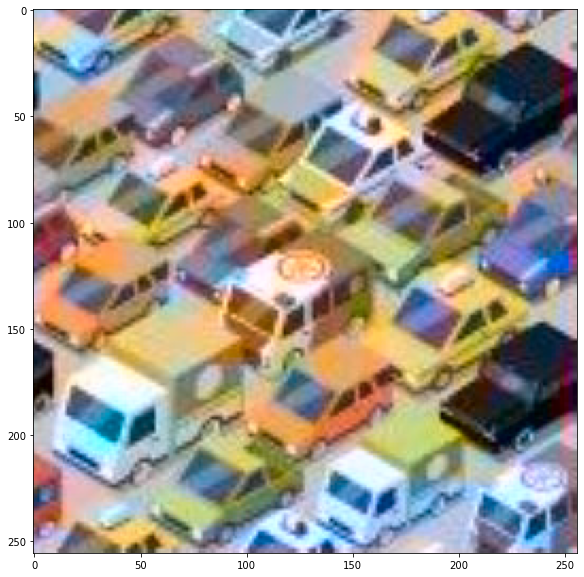

In [56]:
get_photo(image_pathway)

In [45]:
trial = np.expand_dims((256,256),axis = 1)

In [46]:
trial

array([[256],
       [256]])

In [47]:
trial.shape

(2, 1)

In [42]:
trial2 = np.array((256,256))
trial2.shape

(2,)